# Notebook to process and visualize data about faculty research experience.

Requirements:
    
    !pip install pandas
    !pip install openai
    !pip install wordcloud

Also requires [OpenAI account](https://openai.com/) and [OpenAI API key](https://platform.openai.com/account/api-keys). The key must be placed in a text file and pointed 
to in the setup cell (open_ai_inpath) below. Alternatively, store API key in os environment variable and use the commented out snippet in setup below.

License: [CC BY-NC 3.0](https://creativecommons.org/licenses/by-nc/3.0/)


### Setup

In [1]:
import pandas as pd
import time
import openai
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# set paths
bio_inpath = 'data/all_bios.json'
json_outpath = 'data/all_bios_w_research_expertise.json'
open_ai_inpath = 'd:/ai-projects/secrets/SECRETS-OPENAI.txt'

# set OpenAI api key using secrets text file
with open(open_ai_inpath, 'r') as in_file:
    openai.api_key = in_file.readlines()[0]

# # set OpenAI api key using environment variable
# import os
# openai.api_key = os.environ['OPENAI_API_KEY']

### Load faculty bios

To update scraped data, run scrape_bios.ipynb first.

In [3]:
# Load data
df = pd.read_json(bio_inpath)
df

,faculty,name,title,email,href,bio
0,osgoode,Rabiat Akande,Assistant Professor,rakande@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Rabiat Akande works in the fields of...
1,osgoode,Harry Arthurs,Professor Emeritus,harthurs@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,"University Professor, former Dean of Osgoode H..."
2,osgoode,Saptarishi Bandopadhyay,Associate Professor,sbandopadhyay@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,I am an Associate Professor at Osgoode Hall La...
3,osgoode,Stephanie Ben-Ishai,Professor and York University Distinguished Re...,sbenishai@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Stephanie Ben-Ishai is a Distinguish...
4,osgoode,Benjamin L. Berger,Professor & York Research Chair in Pluralism a...,bberger@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Benjamin L. Berger is Professor and ...
...,...,...,...,...,...,...
155,tmu,Asher Alkoby,Associate Professor,aalkoby@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Asher Alkoby is an associate professor in the ...
156,tmu,Pnina Alon-Shenker,Associate Professor,pnina.alon@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Pnina Alon-Shenker is an associate professor i...
157,tmu,Timothy J. Bartkiw,Associate Professor,tbartkiw@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Timothy J. Bartkiw is an associate professor i...
158,tmu,Gil Lan,Associate Professor,glan@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Gil Lan is an associate professor in the Linco...


### Get faculty research expertise using GPT-3.5

Note: Can skip this step if you don't need updates, and just use the saved completions.

In [4]:
# Summarize faculty bios into research expertise keywords

# function to send prompt to GPT-3.5 and return completion
def get_completion(prompt, model_to_use):
    for attempt in range (5):
        try:
            model_output = openai.Completion.create(
            model=model_to_use,
            prompt=prompt,
            temperature= 0,
            max_tokens = 100,
            stop='\n')
            return model_output
        except:
            time.sleep(5)

# Send bio to GPT-3 and get keywords
model = 'text-davinci-003'
prompt_header = 'CONTEXT: The following text is a bio of a Faculty of Law faculty member. \n'\
'TASK: Based on the bio provide a list of up to 5 keywords that best describe the faculty member\'s '\
'main areas of research, separated by semi-colons. List the keywords in order of prominence, with the most '\
'prominent keywords in the bio first. \n BIO: '
suffix_header = ' \nKEYWORDS:'

# iterate through the df and get the completions
for index, row in df.iterrows():
    prompt = prompt_header + row['bio'] + suffix_header
    completion = get_completion(prompt, model).choices[0].text
    df.at[index, 'keywords'] = completion
    time.sleep(.25) # slow down to avoid openai errors

# Save to json for future use
df.to_json(json_outpath, orient='records', indent = 2)

df

,faculty,name,title,email,href,bio,keywords
0,osgoode,Rabiat Akande,Assistant Professor,rakande@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Rabiat Akande works in the fields of...,Legal History; Law and Religion; Constitution...
1,osgoode,Harry Arthurs,Professor Emeritus,harthurs@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,"University Professor, former Dean of Osgoode H...",Legal Education; Legal Profession; Legal Hist...
2,osgoode,Saptarishi Bandopadhyay,Associate Professor,sbandopadhyay@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,I am an Associate Professor at Osgoode Hall La...,Disasters; International Law; State Formation...
3,osgoode,Stephanie Ben-Ishai,Professor and York University Distinguished Re...,sbenishai@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Stephanie Ben-Ishai is a Distinguish...,Bankruptcy; Contract Law; Commercial Law; Fin...
4,osgoode,Benjamin L. Berger,Professor & York Research Chair in Pluralism a...,bberger@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Benjamin L. Berger is Professor and ...,Law and Religion; Criminal and Constitutional...
...,...,...,...,...,...,...,...
155,tmu,Asher Alkoby,Associate Professor,aalkoby@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Asher Alkoby is an associate professor in the ...,Global governance; Corporate social responsib...
156,tmu,Pnina Alon-Shenker,Associate Professor,pnina.alon@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Pnina Alon-Shenker is an associate professor i...,Employment law; labour law; workplace discrim...
157,tmu,Timothy J. Bartkiw,Associate Professor,tbartkiw@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Timothy J. Bartkiw is an associate professor i...,labour law; employment law; industrial relati...
158,tmu,Gil Lan,Associate Professor,glan@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Gil Lan is an associate professor in the Linco...,Corporate governance; comparative law; intern...


### Visualize faculty member research expertise keywords

In [5]:
# Load data (if needed)

df = pd.read_json(json_outpath)
df

,faculty,name,title,email,href,bio,keywords
0,osgoode,Rabiat Akande,Assistant Professor,rakande@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Rabiat Akande works in the fields of...,Legal History; Law and Religion; Constitution...
1,osgoode,Harry Arthurs,Professor Emeritus,harthurs@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,"University Professor, former Dean of Osgoode H...",Legal Education; Legal Profession; Legal Hist...
2,osgoode,Saptarishi Bandopadhyay,Associate Professor,sbandopadhyay@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,I am an Associate Professor at Osgoode Hall La...,Disasters; International Law; State Formation...
3,osgoode,Stephanie Ben-Ishai,Professor and York University Distinguished Re...,sbenishai@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Stephanie Ben-Ishai is a Distinguish...,Bankruptcy; Contract Law; Commercial Law; Fin...
4,osgoode,Benjamin L. Berger,Professor & York Research Chair in Pluralism a...,bberger@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Benjamin L. Berger is Professor and ...,Law and Religion; Criminal and Constitutional...
...,...,...,...,...,...,...,...
155,tmu,Asher Alkoby,Associate Professor,aalkoby@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Asher Alkoby is an associate professor in the ...,Global governance; Corporate social responsib...
156,tmu,Pnina Alon-Shenker,Associate Professor,pnina.alon@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Pnina Alon-Shenker is an associate professor i...,Employment law; labour law; workplace discrim...
157,tmu,Timothy J. Bartkiw,Associate Professor,tbartkiw@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Timothy J. Bartkiw is an associate professor i...,labour law; employment law; industrial relati...
158,tmu,Gil Lan,Associate Professor,glan@torontomu.ca,https://www.torontomu.ca/law/faculty-and-resea...,Gil Lan is an associate professor in the Linco...,Corporate governance; comparative law; intern...


In [27]:
# Function to create word cloud of keywords

def create_word_cloud(df_temp, cmap_color='cool', cmap_number = 800, layout_padding = 4):

    # create stopwords list
    stopwords = [
        'Prize',
        'University',
        'Law School',
        'School of Law',
        'Osgoode',
        'Royal Society',
        'Research Council',
        'Centre'
    ]

    # create list of keywords
    keywords = []
    for index, row in df_temp.iterrows():
        phrases = row['keywords'].split(';')
        for phrase in phrases:
            phrase = phrase.replace('.', ' ')
            phrase = phrase.replace('/', ' and ')
            phrase = phrase.title()
            if not any(stopword in phrase for stopword in stopwords):
                keywords.append(phrase.strip())

    text = '; '.join(keywords)

    # Create a WordCloud object and generate the word cloud
    colour_map = plt.cm.get_cmap(cmap_color, cmap_number)
    wordcloud = WordCloud(width = 1000, height = 800,
                    background_color = 'white',
                    min_font_size = 10,
                    colormap=colour_map).generate(text)

    # Display the word cloud
    plt.figure(figsize = (100,10), facecolor = 'white')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = layout_padding)
    plt.show()

    return None

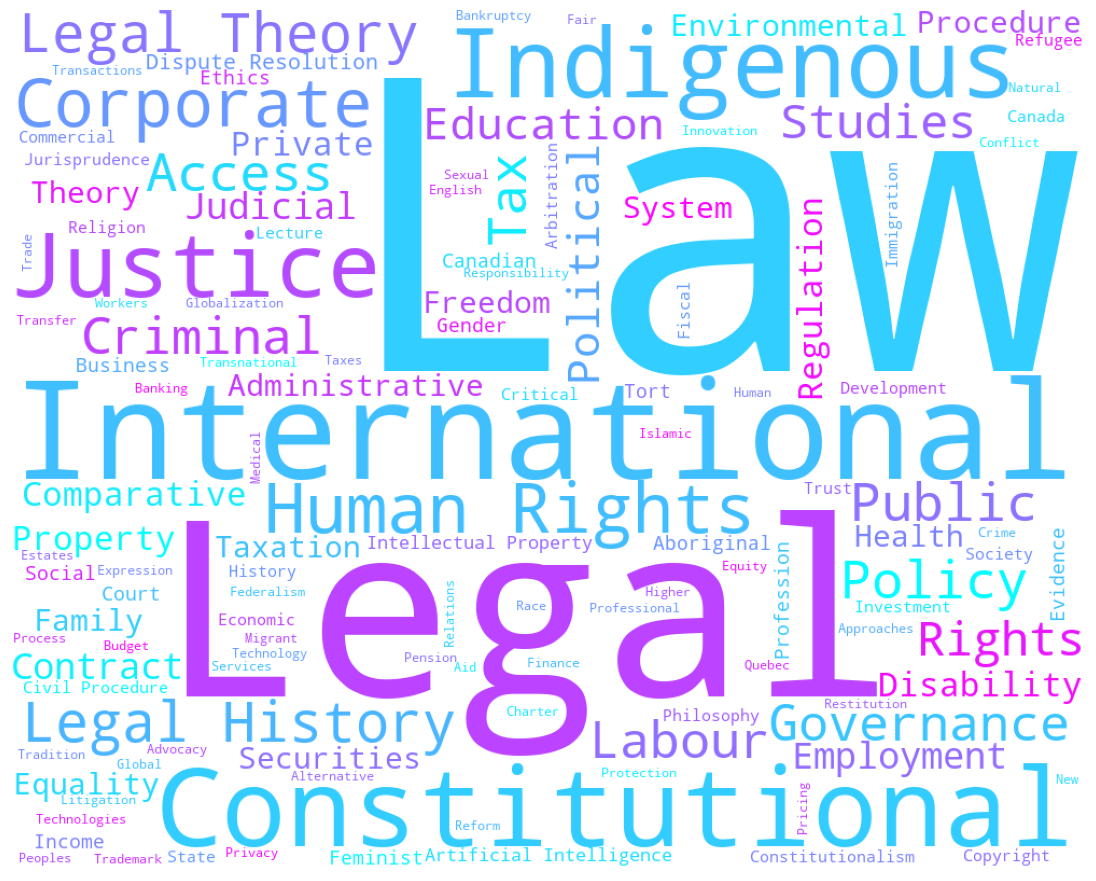

In [39]:
# get Osgoode wordcloud
df_temp = df[df['faculty'] == 'osgoode']
create_word_cloud(df_temp, cmap_color='cool', cmap_number = 800, layout_padding = 5)

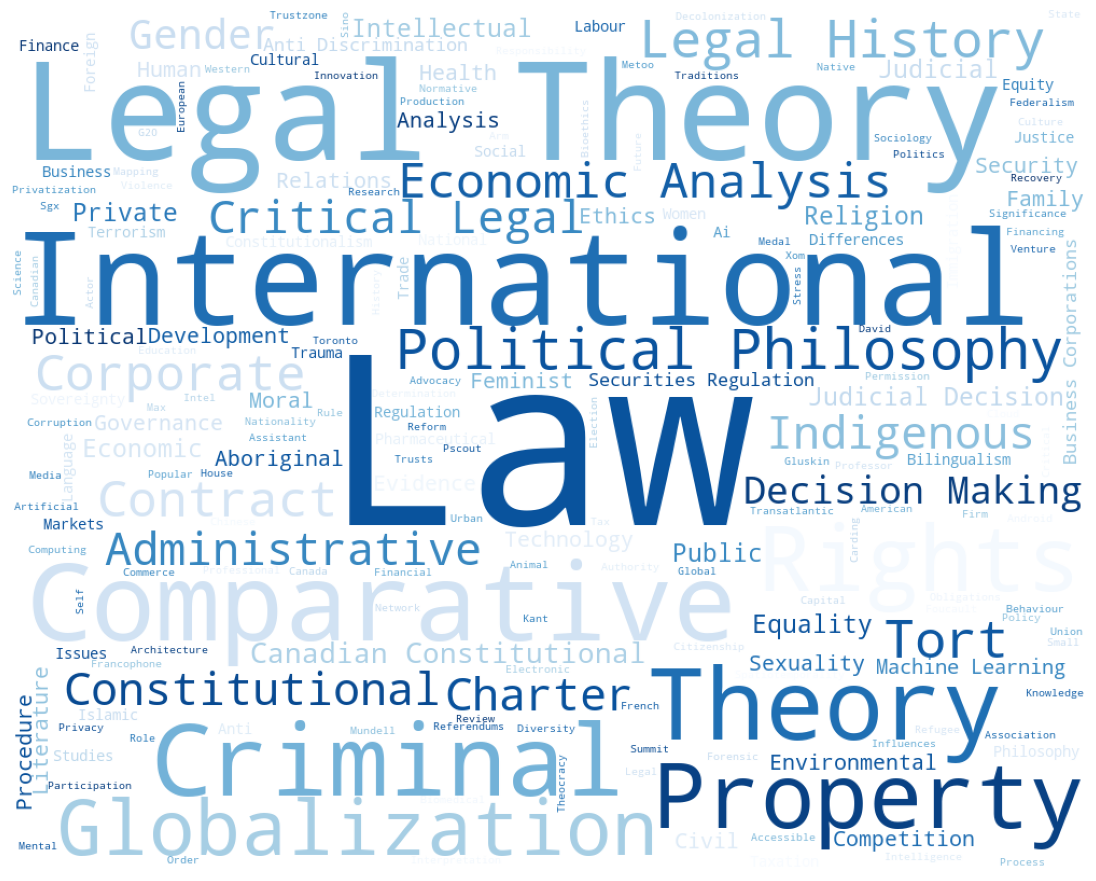

In [36]:
# get UofT wordcloud
df_temp = df[df['faculty'] == 'u_toronto']
create_word_cloud(df_temp, cmap_color='Blues_r', cmap_number = 425, layout_padding = 5)

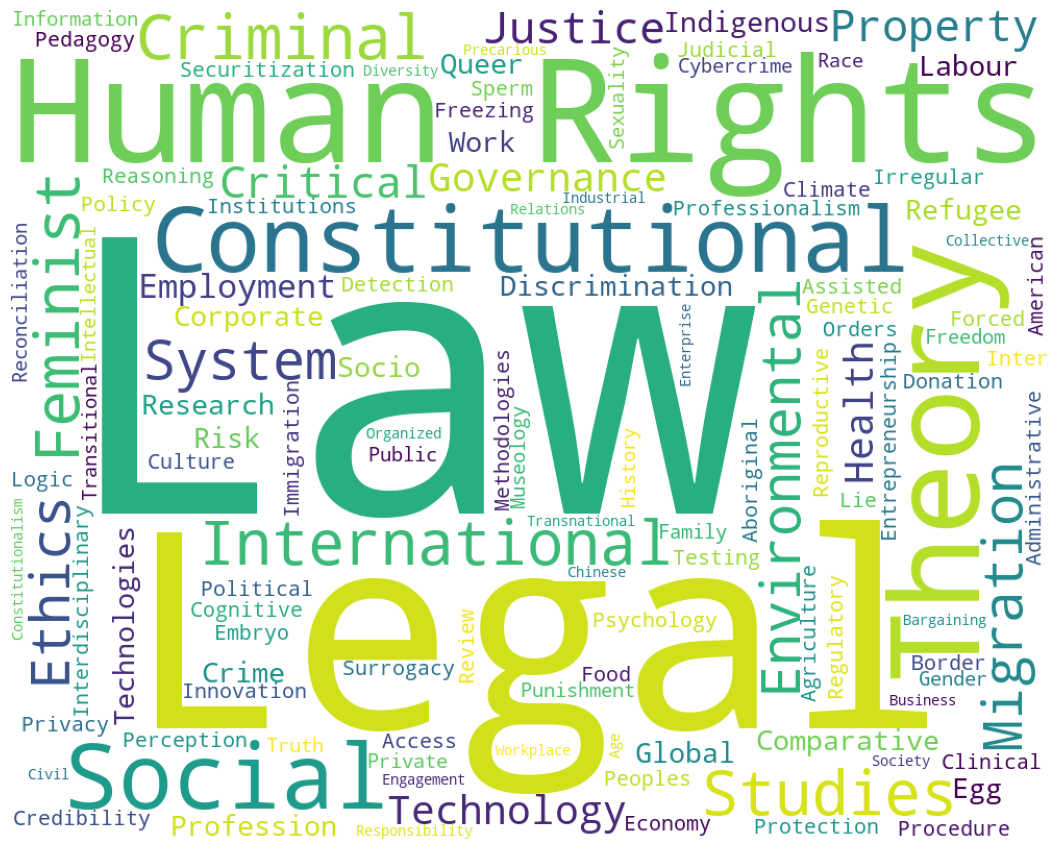

In [37]:
# get TMU wordcloud
df_temp = df[df['faculty'] == 'tmu']
create_word_cloud(df_temp, cmap_color='viridis', cmap_number = 100, layout_padding = 6)